In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in training set data
sfcrimes = pd.read_csv("train.csv")
sfcrimes.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
# Turn crime category into categorical variable

sfcrimes["Category"] = sfcrimes["Category"].astype("category")

from sklearn.preprocessing import LabelEncoder
cat_codes = LabelEncoder()
cat_codes.fit(sfcrimes["Category"].cat.categories)

sfcrimes["CatCodes"] = cat_codes.transform(sfcrimes["Category"])

In [5]:
# Some exploratory plots

## Split into test and training
from sklearn.cross_validation import train_test_split
train, test = train_test_split(sfcrimes, test_size=0.3, random_state=333)

In [92]:
sfcrimes["Category"].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [97]:
len(sfcrimes["Category"].value_counts())

39

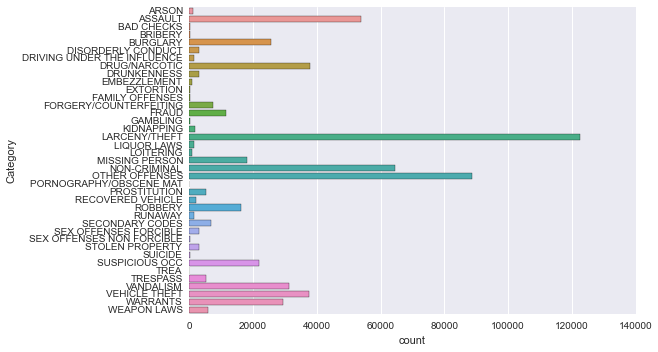

In [6]:
## Distribution of crime categories

sns.countplot(y="Category", data=train)

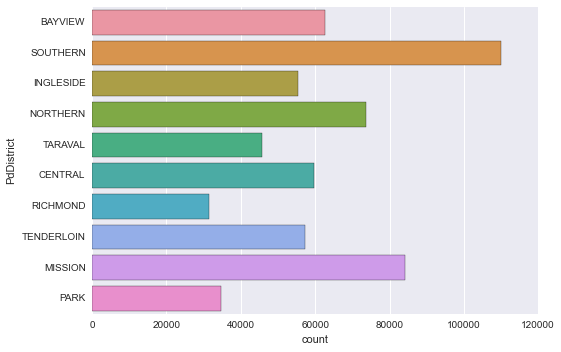

In [7]:
## Distribution of police districts

sns.countplot(y="PdDistrict", data=train)

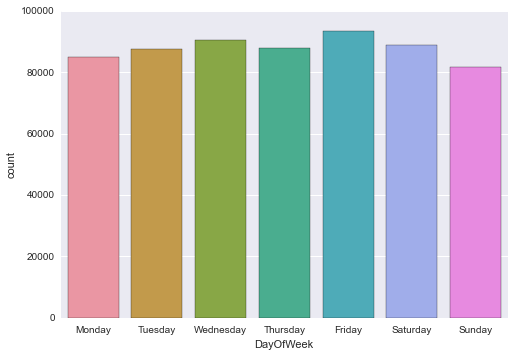

In [8]:
## Distribution of day of week

sns.countplot(x="DayOfWeek",
              data=train,
              order=[x + "day" for x in ["Mon", "Tues", "Wednes", "Thurs",
                                       "Fri", "Satur", "Sun"]])

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


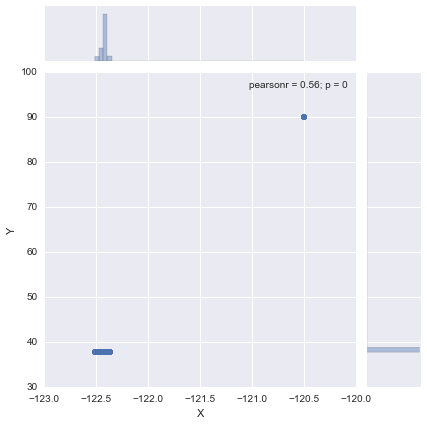

In [9]:
## Distribution of locations

sns.jointplot(x = "X",
              y = "Y",
              data = sfcrimes)

## What to do about extreme outliers in both longitude and latitude?

In [10]:
# Model 1: normalized empirical probabilities

## Predict on testing data based on mean probability for each category 
## in training data
model1 = train["CatCodes"].value_counts()/len(train.index)
model1_pred = np.tile(model1, (len(test.index), 1))
model1_pred.shape

(263415, 39)

In [11]:
## Evaluate Model 1's performance using log-loss metric from Kaggle

from sklearn.metrics import log_loss
log_loss(test["CatCodes"], model1_pred)

5.4603475160606845

In [12]:
# Model 2: using only police district

## Create dummy variables for police district categorical variable
model2_features = pd.get_dummies(train["PdDistrict"], 
                                 prefix="Pd")
model2_features.head(5)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN
710747,1,0,0,0,0,0,0,0,0,0
67284,0,0,0,0,0,0,0,1,0,0
269629,0,0,1,0,0,0,0,0,0,0
716054,0,0,0,0,1,0,0,0,0,0
216556,0,0,0,0,0,0,0,0,1,0


In [13]:
## Predict on testing data using multinomial logistic regression 
## based on police district dummies

from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression().fit(model2_features, 
                                  train["CatCodes"])
test_features = pd.get_dummies(test["PdDistrict"], prefix="Pd")
model2_pred = model2.predict_proba(test_features)
model2_pred.shape

(263415, 39)

In [14]:
## Evaluate Model 2's performance using log-loss metric from Kaggle

log_loss(test["CatCodes"], model2_pred)

2.6171369508460223

In [15]:
## Generate submission using Kaggle's test data

kaggle_test = pd.read_csv("test.csv")
kaggle_features = pd.get_dummies(kaggle_test["PdDistrict"], prefix="Pd")
kaggle_pred = model2.predict_proba(kaggle_features)
colnames = cat_codes.inverse_transform(model2.classes_)
submission = pd.DataFrame(kaggle_pred, 
                          columns=colnames)
submission.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model2.csv",
                  index_label="Id")

In [16]:
# Model 3: adding day of week to police district

## Create dummy variables for day of week categorical variable

model3_features = pd.concat([model2_features, 
                             pd.get_dummies(train["DayOfWeek"])],
                            axis=1)

model3_features.head(5)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
710747,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
67284,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
269629,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
716054,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
216556,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [17]:
## Predict on testing data using multinomial logistic regression 
## based on police district and day of week

model3 = LogisticRegression().fit(model3_features, 
                                  train["CatCodes"])
test_features = pd.concat([pd.get_dummies(test["PdDistrict"], prefix="Pd"),
                           pd.get_dummies(test["DayOfWeek"])],
                          axis=1)               
model3_pred = model3.predict_proba(test_features)
model3_pred.shape

(263415, 39)

In [18]:
## Evaluate Model 3's performance using log-loss metric from Kaggle

log_loss(test["CatCodes"], model3_pred)

## Not especially better than doing police districts alone

2.6141621112529707

In [19]:
# Model 4: random forests

from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(sfcrimes["CatCodes"], 
                     n_folds=5, 
                     shuffle=True, 
                     random_state=333)

In [20]:
## Predict using random forests and 5-fold cross-validation

model4_features = pd.concat([pd.get_dummies(sfcrimes["PdDistrict"],
                                            prefix="Pd"),
                             pd.get_dummies(sfcrimes["DayOfWeek"])],
                            axis=1)
rf = RandomForestClassifier(n_estimators=100,
                            random_state=333)

def log_loss_kfold(alg, train_features, train_target,
                   test_features, test_target):
    train_fit = alg.fit(train_features, train_target)
    test_pred = train_fit.predict_proba(test_features)
    return log_loss(test_target, test_pred)

In [21]:
## Fit and evaluate model

scores = [log_loss_kfold(rf,
                         model4_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model4_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.6160911998797305

In [22]:
# Model 5: Feature engineering

## Identify extreme outliers in longitude and latitude

sfcrimes[['X', 'Y']].quantile(np.linspace(0.9, 1.0, 11))

,X,Y
0.90,-122.397591,37.791466
0.91,-122.396533,37.792838
0.92,-122.395330,37.794283
0.93,-122.393984,37.795822
0.94,-122.392352,37.797346
0.95,-122.390977,37.798383
0.96,-122.389866,37.799771
0.97,-122.388380,37.801574
0.98,-122.386441,37.804425
0.99,-122.380934,37.806758


In [23]:
## Get mean values of longitude and latitude for each district

pd_districts = sfcrimes.groupby("PdDistrict")
pd_means = pd_districts.agg({'X': np.mean,
                             'Y': np.mean})
pd_means

,X,Y
PdDistrict,,
BAYVIEW,-122.393359,37.742516
CENTRAL,-122.409507,37.798740
INGLESIDE,-122.428734,37.729195
MISSION,-122.419393,37.760396
NORTHERN,-122.426428,37.792330
PARK,-122.445369,37.772418
RICHMOND,-122.469782,37.788294
SOUTHERN,-122.405185,37.782573
TARAVAL,-122.477214,37.740736


In [24]:
## Use police district means to impute values for extreme outliers

outliers = (sfcrimes['X'] > -122) | (sfcrimes['Y'] > 38)
imputed_values = pd.DataFrame({idx: pd_means.loc[row['PdDistrict']]
                               for idx, row in sfcrimes[outliers].iterrows()})
sfcrimes.loc[outliers, ('X', 'Y')] = imputed_values.transpose()
sfcrimes[['X', 'Y']].quantile(np.linspace(0.9, 1.0, 11))

,X,Y
0.90,-122.397613,37.791466
0.91,-122.396533,37.792838
0.92,-122.395330,37.794264
0.93,-122.393984,37.795822
0.94,-122.392352,37.797346
0.95,-122.390978,37.798383
0.96,-122.389866,37.799741
0.97,-122.388380,37.801549
0.98,-122.386501,37.804367
0.99,-122.380990,37.806758


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


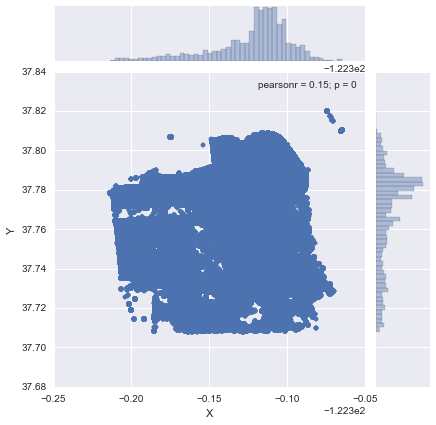

In [25]:
## Check joint distribution of longitude and latitude

sns.jointplot(x = "X",
              y = "Y",
              data = sfcrimes)

In [26]:
## Convert dates column into datetime object

timestamps = pd.to_datetime(sfcrimes["Dates"])
timestamps.index = pd.DatetimeIndex(timestamps)

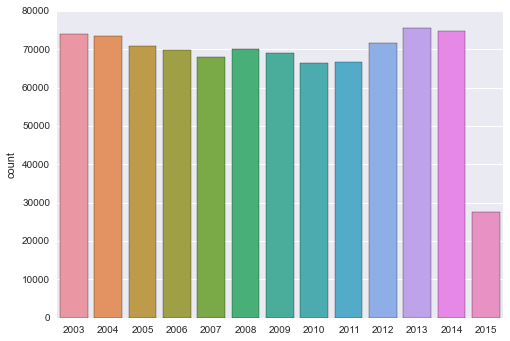

In [27]:
## Distribution of crimes across years

sns.countplot(x = timestamps.index.year,
              order = range(2003, 2016))

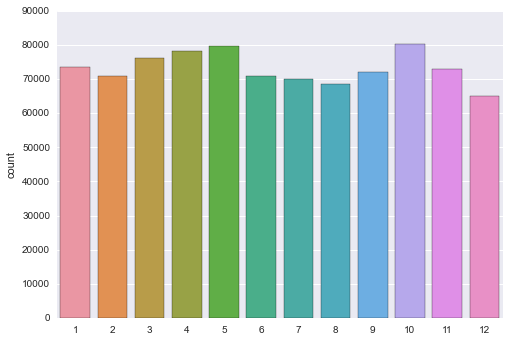

In [28]:
## Distribution of crimes across months

sns.countplot(x = timestamps.index.month,
             order = range(1, 13))

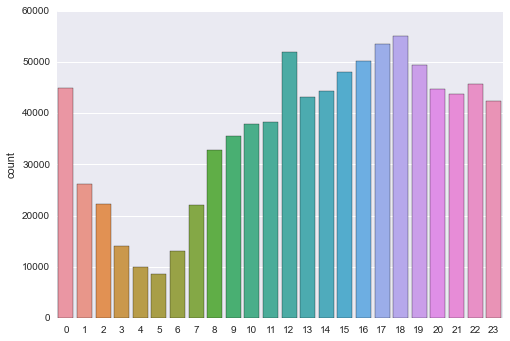

In [29]:
## Distribution of crimes across hours

sns.countplot(x = timestamps.index.hour,
              order = range(24))

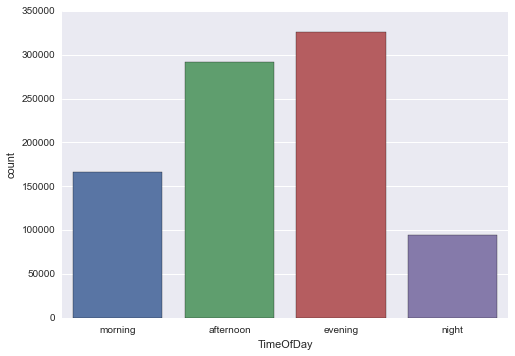

In [30]:
## Construct categorical series for time of day

def time_of_day(hour):
    if hour >= 1 and hour < 7:
        return "night"
    elif hour >=7 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    else:
        return "evening"

sfcrimes["TimeOfDay"] = pd.Series([time_of_day(hour) 
                                   for hour in timestamps.index.hour])
sns.countplot(x = "TimeOfDay",
              data = sfcrimes,
              order = ["morning", "afternoon", "evening", "night"])

In [31]:
## Check for missing data

sfcrimes.apply(lambda x: sum(x.isnull()))

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
CatCodes      0
TimeOfDay     0
dtype: int64

In [33]:
## Build model with year, month, hour, longitude and latitude and scale

from sklearn.preprocessing import maxabs_scale

kf = StratifiedKFold(sfcrimes["CatCodes"], 
                     n_folds=5, 
                     shuffle=True, 
                     random_state=333)

sfcrimes["Year"] = timestamps.index.year
sfcrimes["Month"] = timestamps.index.month
sfcrimes["Hour"] = timestamps.index.hour

feature_names = ["Year", "Month", "Hour", 'X', 'Y']
model5a_features = sfcrimes[feature_names]
model5a_features = pd.DataFrame(maxabs_scale(model5a_features),
                               columns = feature_names)
model5a_features.head(5)

,Year,Month,Hour,X,Y
0,1,0.416667,1,-0.999284,0.998800
1,1,0.416667,1,-0.999284,0.998800
2,1,0.416667,1,-0.999271,0.999483
3,1,0.416667,1,-0.999293,0.999495
4,1,0.416667,1,-0.999389,0.998719


In [34]:
## Evaluate logistic regression model

logr = LogisticRegression()

scores = [log_loss_kfold(logr,
                         model5a_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model5a_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.669819681661441

In [35]:
## Build model with time as qualitative variables

model5b_features = pd.concat([pd.get_dummies(sfcrimes["Year"], 
                                             prefix = "Y"),
                              pd.get_dummies(sfcrimes["Month"], 
                                             prefix = "M"),
                              pd.get_dummies(sfcrimes["TimeOfDay"],
                                             prefix = "Time"),
                              pd.get_dummies(sfcrimes["PdDistrict"],
                                             prefix = "Pd"),
                              pd.Series(maxabs_scale(sfcrimes['X']),
                                        name = 'X'), 
                              pd.Series(maxabs_scale(sfcrimes['Y']),
                                        name = 'Y')],
                             axis = 1)
model5b_features.head(5)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN,X,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.999284,0.998800
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.999284,0.998800
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.999271,0.999483
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.999293,0.999495
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.999389,0.998719


In [36]:
## Evaluate logistic regression model

scores = [log_loss_kfold(logr,
                         model5b_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model5b_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.575608439211817

In [37]:
## Fit logistic regression model on total training set

model5b = logr.fit(model5b_features, sfcrimes["CatCodes"])

In [38]:
## Preprocess Kaggle's test data

kaggle_test = pd.read_csv("test.csv")

kaggle_outliers = (kaggle_test['X'] > -122) | (kaggle_test['Y'] > 38)
kaggle_imputed = pd.DataFrame({idx: pd_means.loc[row['PdDistrict']]
                               for idx, row in kaggle_test[kaggle_outliers].iterrows()})
kaggle_test.loc[kaggle_outliers, ('X', 'Y')] = kaggle_imputed.transpose()

kaggle_timestamps = pd.to_datetime(kaggle_test["Dates"])
kaggle_timestamps.index = pd.DatetimeIndex(kaggle_timestamps)

kaggle_test["Year"] = kaggle_timestamps.index.year
kaggle_test["Month"] = kaggle_timestamps.index.month
kaggle_test["TimeOfDay"] = pd.Series([time_of_day(hour) 
                                      for hour in kaggle_timestamps.index.hour])

kaggle_features = pd.concat([pd.get_dummies(kaggle_test["Year"], 
                                            prefix = "Y"),
                             pd.get_dummies(kaggle_test["Month"], 
                                            prefix = "M"),
                             pd.get_dummies(kaggle_test["TimeOfDay"],
                                            prefix = "Time"),
                             pd.get_dummies(kaggle_test["PdDistrict"],
                                            prefix = "Pd"),
                             pd.Series(maxabs_scale(kaggle_test['X']),
                                        name = 'X'), 
                             pd.Series(maxabs_scale(kaggle_test['Y']),
                                        name = 'Y')],
                             axis = 1)
kaggle_features.head(5)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN,X,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.999069,0.997737
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.999003,0.997668
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.999285,0.999249
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-0.999378,0.997377
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-0.999378,0.997377


In [39]:
## Predict on Kaggle's test data using model

kaggle_pred = model5b.predict_proba(kaggle_features)
colnames = cat_codes.inverse_transform(model5b.classes_)
submission = pd.DataFrame(kaggle_pred, 
                          columns=colnames)
submission.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model5b.csv",
                  index_label="Id")

In [40]:
# Model 6: Clustering longitude and latitude

## Use k-means clustering to identify clusters
from sklearn.cluster import KMeans

k10 = KMeans(n_clusters = 10,
             max_iter = 100,
             random_state = 333).fit_predict(sfcrimes[['X', 'Y']])

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


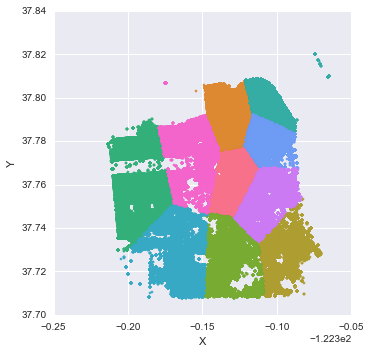

In [82]:
## Plot clusters

sfcrimes["Neighborhood"] = k10
g = sns.PairGrid(data = sfcrimes,
                 hue = "Neighborhood",
                 palette = "husl",
                 x_vars = ['X'],
                 y_vars = ['Y'],
                 hue_kws = {"marker": ['.' for n in range(10)]},
                 size = 5)
g = g.map(plt.scatter)

In [53]:
kn = [KMeans(n_clusters = n,
             max_iter = 100,
             random_state = 333).fit(sfcrimes[['X', 'Y']])
      for n in range(50, 750, 50)]

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


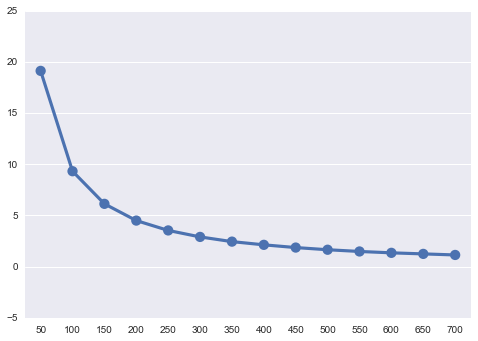

In [57]:
sns.pointplot(x = [x for x in range(50, 750, 50)],
              y = [k.inertia_ for k in kn],
              ci = None)

In [62]:
k150 = KMeans(n_clusters = 150,
              max_iter = 100,
              random_state = 333).fit(sfcrimes[['X', 'Y']])

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


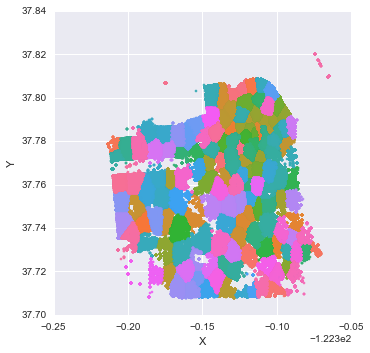

In [84]:
sfcrimes["Neighborhood"] = k150.predict(sfcrimes[['X', 'Y']])
g = sns.PairGrid(data = sfcrimes,
                 hue = "Neighborhood",
                 palette = "husl",
                 x_vars = ['X'],
                 y_vars = ['Y'],
                 hue_kws = {"marker": ['.' for n in range(150)]},
                 size = 5)
g = g.map(plt.scatter)

In [118]:
model6_features = pd.concat([pd.get_dummies(sfcrimes["Year"],
                                            prefix = "Y"),
                             pd.get_dummies(sfcrimes["Month"],
                                            prefix = "M"),
                             pd.get_dummies(sfcrimes["TimeOfDay"],
                                            prefix = "Time"),
                             pd.get_dummies(sfcrimes["DayOfWeek"]),
                             pd.get_dummies(sfcrimes["PdDistrict"],
                                            prefix = "Pd"),
                             pd.get_dummies(sfcrimes["Neighborhood"],
                                            prefix = "N")],
                            axis = 1)
model6_features.head(5)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,N_140,N_141,N_142,N_143,N_144,N_145,N_146,N_147,N_148,N_149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
scores = [log_loss_kfold(logr,
                         model6_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model6_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.4945534184824858

In [87]:
model6 = logr.fit(model6_features, sfcrimes["CatCodes"])

In [88]:
kaggle_test["Neighborhood"] = k150.predict(kaggle_test[['X', 'Y']])

kaggle_features = pd.concat([pd.get_dummies(kaggle_test["Year"], 
                                            prefix = "Y"),
                             pd.get_dummies(kaggle_test["Month"], 
                                            prefix = "M"),
                             pd.get_dummies(kaggle_test["DayOfWeek"]),
                             pd.get_dummies(kaggle_test["TimeOfDay"],
                                            prefix = "Time"),
                             pd.get_dummies(kaggle_test["PdDistrict"],
                                            prefix = "Pd"),
                             pd.get_dummies(kaggle_test["Neighborhood"])],
                            axis = 1)
kaggle_features.head(5)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
kaggle_pred = model6.predict_proba(kaggle_features)
colnames = cat_codes.inverse_transform(model6a.classes_)
submission = pd.DataFrame(kaggle_pred, 
                          columns=colnames)
submission.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model6.csv",
                  index_label="Id")

In [108]:
## Model 7: Combine multiple algorithms

from sklearn.ensemble import GradientBoostingClassifier

def log_loss_multi(alg_list, train_features, train_target,
                   test_features, test_target):
    predictions = np.array([alg.fit(train_features,
                                    train_target).predict_proba(test_features)
                            for alg in alg_list])
    means = predictions.mean(axis = 0)
    normalized_means = means.div(means.sum(axis = 1), 
                                       axis = 0)
    return log_loss(test_target, normalized_means)

In [109]:
rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_leaf = 5,
                            max_depth = 40,
                            random_state = 333)

gb = GradientBoostingClassifier(n_estimators = 10,
                                min_samples_leaf = 5, 
                                max_depth = 40, 
                                random_state = 333)

scores = [log_loss_multi([logr, rf, gb],
                         model6_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model6_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

KeyboardInterrupt: 

In [ ]:
rf_model = rf.fit(model6_features, sfcrimes["CatCodes"])
gb_model = gb.fit(model6_features, sfcrimes["CatCodes"])

def combine_models(model_list, test_data):
    predict = np.array([model.predict_proba(test_data)
                            for model in model_list])
    mean_predict = predict.mean(axis = 0)
    normalize = mean_predict.div(mean_predict.sum(axis = 1),
                                 axis = 0)
    return normalize

In [ ]:
kaggle_pred = combine_models([logr_model, rf_model, gb_model], kaggle_features)
colnames = cat_codes.inverse_transform(logr_model.classes_)
submission = pd.DataFrame(kaggle_pred, 
                          columns=colnames)
submission.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model7.csv",
                  index_label="Id")